# Cropping Dog Faces
## Overview
In this competition, cropping only dogs may be important.  
This kernel attempts to crop only front faces of dogs just like CelebA.  

## Score
Just cropped images results **81.2265** in pubilc LB  
Linear combinations of the principal components bt PCA results **121.16142** in public LB  
Linear combinations of the principal components by Kernel PCA results **159.69548** in public LB but it looks better than PCA's :)

## Method
I use Cascade Classifier and Haarlike features in OpenCV.  
Note that this data cleaning method is in gray zone because these haarlike features are just pretrained weights even if this kernel doesn't use any data outside of kernel.

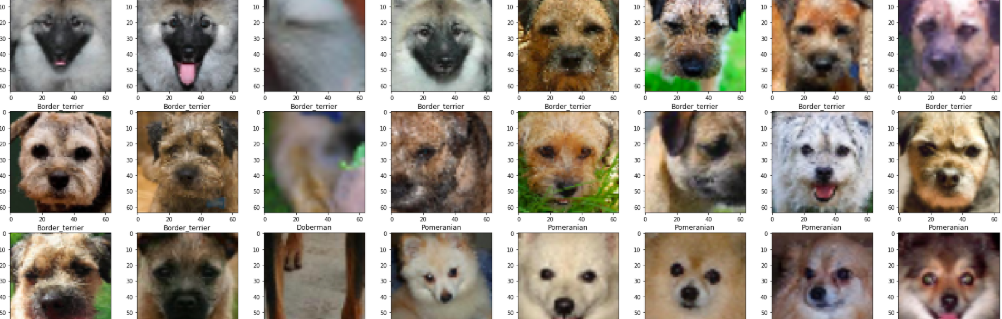

# Libraries

In [ ]:
%load_ext tensorboard.notebook
%matplotlib inline

import os
import shutil
from dataclasses import dataclass
from functools import partial
import pathlib
import time
import xml.etree.ElementTree as ET
import zipfile

import numpy as np
import pandas as pd
import skimage
from PIL import Image
import cv2

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
import albumentations as albu
from tqdm import tqdm_notebook as tqdm

# Original dataset

In [ ]:
@dataclass
class Example:
    img: np.ndarray
    category: str
    difficult: int
    transform: object = None

    def read_img(self):
        # read and crop
        img = self.img

        if self.transform is not None:
            img = self.transform(image=img)['image']

        # convert to ndarray and transpose HWC => CHW
        img = np.array(img).transpose(2, 0, 1)
        return img

    def show(self):
        img = (self.read_img() + 1) / 2
        plt.imshow(img.transpose(1, 2, 0))
        plt.title(self.category)

class DogDataset(Dataset):
    def __init__(self,
                 img_dir='../input/all-dogs/all-dogs/',
                 anno_dir='../input/annotation/Annotation/',
                 transform=None,
                 examples=None):
        self.img_dir = pathlib.Path(img_dir)
        self.anno_dir = pathlib.Path(anno_dir)
        self.transform = transform
        self.preprocess = albu.Compose([
            albu.SmallestMaxSize(64),
        ])
        
        if examples is None:
            self.examples = self._correct_examples()
        else:
            self.examples = examples

        self.categories = sorted(set([e.category for e in self.examples]))
        self.categ2id = dict(zip(self.categories, range(len(self.categories))))
        
    def _correct_examples(self):
        examples = []
        for anno in tqdm(list(self.anno_dir.glob('*/*'))):
            tree = ET.parse(anno)
            root = tree.getroot()

            img_path = self.img_dir / f'{root.find("filename").text}.jpg'
            if not img_path.exists():
                continue

            objects = root.findall('object')
            for obj in objects:
                examples.append(self._create_example(img_path, obj))
        return examples

    def _create_example(self, img_path, obj):
        # reading bound box
        bbox = obj.find('bndbox')
        # read and preprocess image
        img = skimage.io.imread(img_path)
        xmin=int(bbox.find('xmin').text)
        ymin=int(bbox.find('ymin').text)
        xmax=int(bbox.find('xmax').text)
        ymax=int(bbox.find('ymax').text)
        img = img[ymin:ymax, xmin:xmax]
        img = self.preprocess(image=img)['image']

        # add example
        return Example(
            img=img,
            category=obj.find('name').text,
            difficult=int(obj.find('difficult').text),
            transform=self.transform,
        )
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        e = self.examples[i]
        img = e.read_img()

        categ_id = self.categ2id[e.category]
        return img, categ_id

    def show_examples(self, indices=None, n_cols=8):
        if indices is None:
            indices = np.random.randint(0, len(self), n_cols)

        n_rows = (len(indices)-1) // n_cols + 1

        fig = plt.figure(figsize=(n_cols*4, n_rows*4))
        for i, idx in enumerate(indices, 1):
            fig.add_subplot(n_rows, n_cols, i)
            self.examples[idx].show()
        plt.show()

In [ ]:
%%time

transform = albu.Compose([
    albu.CenterCrop(64, 64),
    albu.HorizontalFlip(p=0.5),
    albu.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = DogDataset(
    transform=transform,
)

print(dataset)
dataset.show_examples()

# Haarlike features

In [ ]:
ls /opt/conda/lib/python3.6/site-packages/cv2/data/haarcascade_*.xml

# Crop dog faces
OpenCV doesn't include any haarlike features for detecting dog faces.  
So, I alternate it by that for cat faces and human faces.

In [ ]:
def crop_with_facebox(img, pos):
    pos = pos[0]
    left, right = pos[0], pos[0]+pos[2]
    top, bottom = pos[1], pos[1]+pos[3]
    img = img[top:bottom, left:right]
    return img

def create_cropped_dataset(dataset):
    rescale = albu.SmallestMaxSize(64)

    cascade_file_path = '/opt/conda/lib/python3.6/site-packages/cv2/data/haarcascade_{}.xml'
    
    # classifiers are prioritized
    ordered_classifiers = [
        (cv2.CascadeClassifier(cascade_file_path.format('frontalcatface_extended')), crop_with_facebox),
        (cv2.CascadeClassifier(cascade_file_path.format('frontalcatface')), crop_with_facebox),
        (cv2.CascadeClassifier(cascade_file_path.format('frontalface_default')), crop_with_facebox),
        (cv2.CascadeClassifier(cascade_file_path.format('frontalface_alt')), crop_with_facebox),
        (cv2.CascadeClassifier(cascade_file_path.format('frontalface_alt2')), crop_with_facebox),
    ]

    cropped_examples = []
    for i, e in enumerate(tqdm(dataset.examples)):
        grayimg = cv2.cvtColor(e.img, cv2.COLOR_RGB2GRAY)
        for clf, crop_fn in ordered_classifiers:
            pos = clf.detectMultiScale(grayimg)
            if len(pos) != 0:
                break

        if len(pos) == 0:
            continue

        img = crop_fn(e.img, pos)
        if img is None:
            continue

        img = rescale(image=img)['image']
        cropped_examples.append(Example(
            img=img, category=e.category,
            difficult=e.difficult,
            transform=e.transform,
        ))

    return DogDataset(examples=cropped_examples)

In [ ]:
%%time
cropped_dataset = create_cropped_dataset(dataset)
print(len(cropped_dataset))
cropped_dataset.show_examples()

In [ ]:
cropped_dataset.show_examples(range(len(cropped_dataset)))

# Generate dogs by using principal components
Since the cropped dog images are well aligned, we can simply generate dog images as linear combination of principal components.

In [ ]:
# collect images by the categories.
categ_imgs = {}
for x, c in cropped_dataset:
    categ_imgs[c] = categ_imgs.get(c, []) + [x]

# select categories which are successfully cropped more than 10 images
categ_imgs = dict(sorted(filter(lambda item: len(item[1])>=10, categ_imgs.items())))
len(categ_imgs)

generated image examples

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

def generate_images_by_PCA(real_imgs, n):
    x = np.array(real_imgs)
    x = x.transpose(0, 2, 3, 1).reshape(len(x), -1)

    n_components = len(x)-1
    pca = KernelPCA(n_components, kernel='rbf', fit_inverse_transform=True)
    pca.fit(x)

    z = np.random.randn(n, n_components) * np.sqrt(pca.lambdas_[None, :])
    imgs = pca.inverse_transform(z).reshape(n, 64, 64, 3)
    imgs -= imgs.min() * 0.8
    imgs = imgs.clip(0, 1)
    return imgs

n = 10
for c in categ_imgs:
    imgs = generate_images_by_PCA(categ_imgs[c], n)

    fig = plt.figure(figsize=(4*n, 8))
    for i, img in enumerate(imgs, 1):
        fig.add_subplot(2, n, i)
        plt.imshow(img)
        plt.title(cropped_dataset.categories[c])
        fig.add_subplot(2, n, n+i)
        plt.hist(img.flatten())
        
    plt.show()

Save images

In [ ]:
zipname = f'images.zip'
categ_ids = list(categ_imgs.keys())
with zipfile.PyZipFile(zipname, mode='w') as z:
    for i in tqdm(range(1000)):
        real_imgs = categ_imgs[categ_ids[i%len(categ_ids)]]
        imgs = generate_images_by_PCA(real_imgs, 10)
        imgs = (imgs*255).astype('uint8')
        for j, img in enumerate(imgs):
            fname = f'{i:03d}{j:01d}.png'
            Image.fromarray(img).save(fname, 'PNG')
            z.write(fname)
            os.remove(fname)